# Task 3 — GAN Dynamics


## 0. Environment & Debug Flags

In [1]:
import os, torch
# Enable during debugging to locate the exact failing op (slower):
# os.environ['CUDA_LAUNCH_BLOCKING']='1'
# torch.autograd.set_detect_anomaly(True)
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

PyTorch: 2.8.0+cu126
CUDA available: True


## 1. Imports

In [2]:
import math, random, time
from pathlib import Path
from types import SimpleNamespace
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

## 2. Reproducibility & Device

In [3]:
def set_seed(seed=1337, deterministic=False):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = not deterministic
    torch.backends.cudnn.deterministic = deterministic

set_seed(42, deterministic=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.set_float32_matmul_precision('high')

device(type='cuda')

## 3. Config (baseline defaults)

In [4]:
CFG = SimpleNamespace(
    data_root = './data',
    batch_size = 128,
    workers = 4,
    z_dim = 100,
    g_hid = (256, 512),
    d_hid = (256, 256),
    img_flat = 28*28,
    lr_g = 2e-4,
    lr_d = 2e-4,
    beta1 = 0.5,
    beta2 = 0.999,
    epochs = 20,
    out_dir = './runs/task3_gan',
    log_every = 100,
    sample_every = 500,
    grad_clip = 1.0,
)
Path(CFG.out_dir).mkdir(parents=True, exist_ok=True)
print(CFG)

namespace(data_root='./data', batch_size=128, workers=4, z_dim=100, g_hid=(256, 512), d_hid=(256, 256), img_flat=784, lr_g=0.0002, lr_d=0.0002, beta1=0.5, beta2=0.999, epochs=20, out_dir='./runs/task3_gan', log_every=100, sample_every=500, grad_clip=1.0)


## 4. Data — MNIST normalized to [-1, 1]

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])
train_ds = datasets.MNIST(CFG.data_root, train=True, download=True, transform=tfms)
test_ds  = datasets.MNIST(CFG.data_root, train=False, download=True, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,
                      num_workers=CFG.workers, pin_memory=(device.type=='cuda'),
                      persistent_workers=(CFG.workers>0))
test_dl  = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False,
                      num_workers=CFG.workers, pin_memory=(device.type=='cuda'),
                      persistent_workers=(CFG.workers>0))
xb, yb = next(iter(train_dl))
print('Batch:', xb.shape, yb.shape, yb.dtype, 'min/max:', float(xb.min()), float(xb.max()))
assert xb.ndim==4 and xb.shape[1]==1 and xb.shape[-1]==28, 'Expect NCHW 1x28x28'

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


Batch: torch.Size([128, 1, 28, 28]) torch.Size([128]) torch.int64 min/max: -1.0 1.0


## 5. Models — MLP Generator & Discriminator (Sigmoid + BCELoss)

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden=(256,512), out_dim=784):
        super().__init__()
        dims=[z_dim,*hidden,out_dim]; layers=[]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.BatchNorm1d(dims[i+1]), nn.ReLU(True)]
        layers += [nn.Linear(dims[-2],dims[-1]), nn.Tanh()]  # output in [-1,1]
        self.net=nn.Sequential(*layers)
    def forward(self,z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim=784, hidden=(256,256), p_drop=0.0):
        super().__init__()
        dims=[in_dim,*hidden,1]; layers=[]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i],dims[i+1]), nn.LeakyReLU(0.2, inplace=True)]
            if p_drop>0: layers += [nn.Dropout(p_drop)]
        layers += [nn.Linear(dims[-2],dims[-1]), nn.Sigmoid()]  # BCELoss expects probs
        self.net=nn.Sequential(*layers)
    def forward(self,x_flat): return self.net(x_flat).squeeze(1)  # (B,)

## 6. Initialization & Helpers

In [7]:
def init_weights_normal(m, std=0.02):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, std)
        if m.bias is not None: nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight, 1.0, std); nn.init.zeros_(m.bias)

def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters())

def plot_grid(tensor, title=None, nrow=8):
    grid = vutils.make_grid(tensor, nrow=nrow, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6)); plt.axis('off')
    if title: plt.title(title)
    plt.imshow(grid.permute(1,2,0).cpu()); plt.show()

## 7. Build Baseline Models

In [8]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
print(f'G params: {count_params(G)/1e6:.2f}M, D params: {count_params(D)/1e6:.2f}M')

G params: 0.56M, D params: 0.27M


## 8. Optimizers & Loss

In [9]:
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d, betas=(CFG.beta1, CFG.beta2))
bce = nn.BCELoss()
fixed_z = torch.randn(64, CFG.z_dim, device=device)

## 9. Training Utilities




In [10]:
def one_step(imgs, label_smooth=None, d_steps=1, g_steps=1):
    B = imgs.size(0)
    x = imgs.view(B,-1).to(device, non_blocking=True)
    real_lbl = torch.full((B,), float(0.9 if label_smooth else 1.0), device=device)
    fake_lbl = torch.full((B,), 0.0, device=device)

    # D updates
    loss_d_val = 0.0
    for _ in range(d_steps):
        optD.zero_grad(set_to_none=True)
        pr = D(x); assert pr.shape==(B,), f'D(real) shape mismatch {pr.shape}'
        loss_real = bce(pr, real_lbl)
        z = torch.randn(B, CFG.z_dim, device=device)
        fake = G(z).detach()
        pf = D(fake); assert pf.shape==(B,), f'D(fake) shape mismatch {pf.shape}'
        loss_fake = bce(pf, fake_lbl)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        if CFG.grad_clip>0: torch.nn.utils.clip_grad_norm_(D.parameters(), CFG.grad_clip)
        optD.step()
        loss_d_val += float(loss_d.item())
    loss_d_val /= d_steps

    # G updates (non-saturating)
    loss_g_val = 0.0
    for _ in range(g_steps):
        optG.zero_grad(set_to_none=True)
        z = torch.randn(B, CFG.z_dim, device=device)
        fake = G(z)
        pf = D(fake)
        loss_g = bce(pf, real_lbl)
        loss_g.backward()
        if CFG.grad_clip>0: torch.nn.utils.clip_grad_norm_(G.parameters(), CFG.grad_clip)
        optG.step()
        loss_g_val += float(loss_g.item())
    loss_g_val /= g_steps

    with torch.no_grad():
        pr_m = float(pr.mean().item()); pf_m = float(pf.mean().item())
    return loss_d_val, loss_g_val, pr_m, pf_m

## 10. Baseline Training

In [11]:
loss_hist={'d':[], 'g':[], 'pr':[], 'pf':[]}
global_step=0
samples_dir=Path(CFG.out_dir)/'baseline_samples'; samples_dir.mkdir(parents=True, exist_ok=True)
for epoch in range(1, CFG.epochs+1):
    for i,(imgs,_) in enumerate(train_dl):
        d,g,pr_m,pf_m = one_step(imgs, label_smooth=None, d_steps=1, g_steps=1)
        loss_hist['d'].append(d); loss_hist['g'].append(g)
        loss_hist['pr'].append(pr_m); loss_hist['pf'].append(pf_m)
        if global_step % CFG.log_every==0:
            print(f'[baseline] epoch {epoch:03d} step {global_step:06d} | D {d:.4f} G {g:.4f} | D(real)~{pr_m:.3f} D(fake)~{pf_m:.3f}')
        if global_step % CFG.sample_every==0:
            with torch.no_grad(): fake=G(fixed_z).view(-1,1,28,28).cpu()
            vutils.save_image(fake, samples_dir/f'e{epoch:03d}_s{global_step:06d}.png', nrow=8, normalize=True, value_range=(-1,1))
        global_step += 1
print('Baseline training finished.')

[baseline] epoch 001 step 000000 | D 1.3906 G 0.6990 | D(real)~0.496 D(fake)~0.497
[baseline] epoch 001 step 000100 | D 1.3699 G 0.6839 | D(real)~0.543 D(fake)~0.505
[baseline] epoch 001 step 000200 | D 1.4307 G 0.7511 | D(real)~0.564 D(fake)~0.473
[baseline] epoch 001 step 000300 | D 1.0394 G 0.9563 | D(real)~0.710 D(fake)~0.391
[baseline] epoch 001 step 000400 | D 1.2904 G 0.9251 | D(real)~0.591 D(fake)~0.399
[baseline] epoch 002 step 000500 | D 1.1000 G 0.9122 | D(real)~0.557 D(fake)~0.407
[baseline] epoch 002 step 000600 | D 1.0401 G 1.3964 | D(real)~0.627 D(fake)~0.250
[baseline] epoch 002 step 000700 | D 0.9014 G 1.6894 | D(real)~0.733 D(fake)~0.190
[baseline] epoch 002 step 000800 | D 1.3530 G 1.3653 | D(real)~0.613 D(fake)~0.260
[baseline] epoch 002 step 000900 | D 1.3253 G 1.1078 | D(real)~0.575 D(fake)~0.335
[baseline] epoch 003 step 001000 | D 1.1418 G 0.8905 | D(real)~0.551 D(fake)~0.417
[baseline] epoch 003 step 001100 | D 1.3381 G 1.2496 | D(real)~0.663 D(fake)~0.290
[bas

## 11. Baseline: Loss Curves & Sample Grid

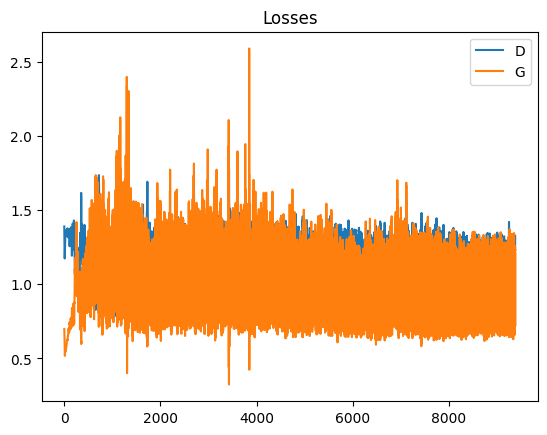

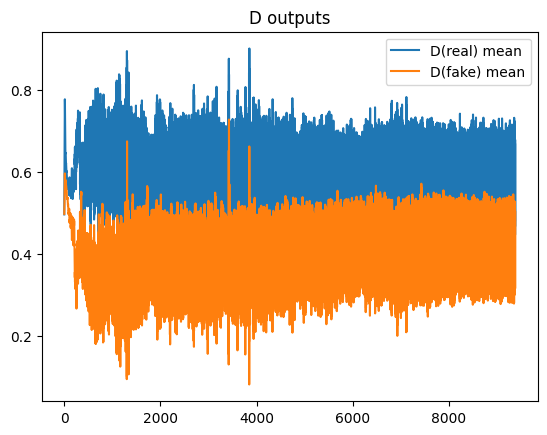

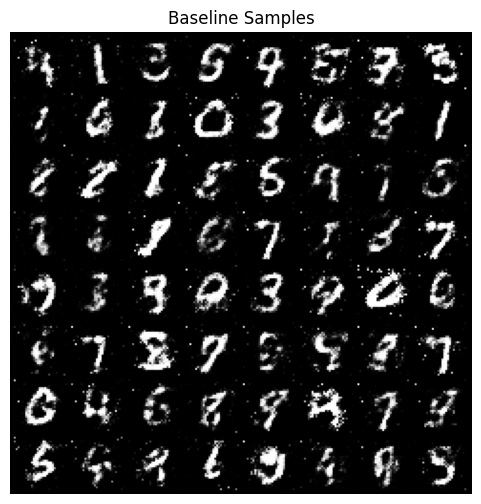

In [12]:
plt.figure(); plt.plot(loss_hist['d'],label='D'); plt.plot(loss_hist['g'],label='G'); plt.legend(); plt.title('Losses'); plt.show()
plt.figure(); plt.plot(loss_hist['pr'],label='D(real) mean'); plt.plot(loss_hist['pf'],label='D(fake) mean'); plt.legend(); plt.title('D outputs'); plt.show()
with torch.no_grad(): fake=G(fixed_z).view(-1,1,28,28).cpu()
plot_grid(fake, title='Baseline Samples')

## 12. Experiment 1 — Gradient Vanishing (overpower D)

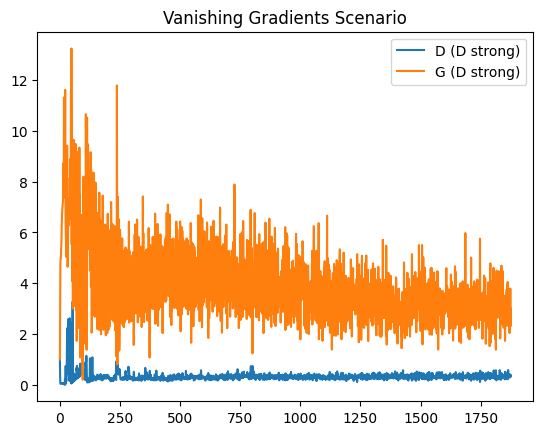

Observation: D loss -> low, G loss tends to stay high/flat when D dominates.


In [13]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d*5, betas=(CFG.beta1, CFG.beta2))
hist_vanish={'d':[],'g':[]}
for epoch in range(1,5):
    for imgs,_ in train_dl:
        d,g,_,_ = one_step(imgs, label_smooth=None, d_steps=5, g_steps=1)
        hist_vanish['d'].append(d); hist_vanish['g'].append(g)
plt.figure(); plt.plot(hist_vanish['d'],label='D (D strong)'); plt.plot(hist_vanish['g'],label='G (D strong)'); plt.legend(); plt.title('Vanishing Gradients Scenario'); plt.show()
print('Observation: D loss -> low, G loss tends to stay high/flat when D dominates.')

## 13. Mitigation — One-sided Label Smoothing (balanced steps)

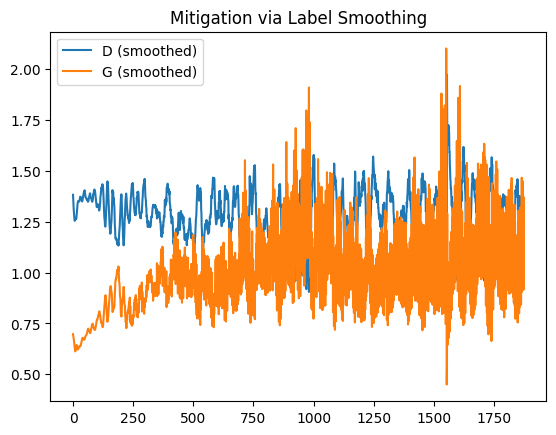

Observation: G receives healthier gradients; loss decreases compared to dominated case.


In [14]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d, betas=(CFG.beta1, CFG.beta2))
hist_mitig={'d':[],'g':[]}
for epoch in range(1,5):
    for imgs,_ in train_dl:
        d,g,_,_ = one_step(imgs, label_smooth=True, d_steps=1, g_steps=1)
        hist_mitig['d'].append(d); hist_mitig['g'].append(g)
plt.figure(); plt.plot(hist_mitig['d'],label='D (smoothed)'); plt.plot(hist_mitig['g'],label='G (smoothed)'); plt.legend(); plt.title('Mitigation via Label Smoothing'); plt.show()
print('Observation: G receives healthier gradients; loss decreases compared to dominated case.')

## 14. Experiment 2 — Mode Collapse (overpower G)

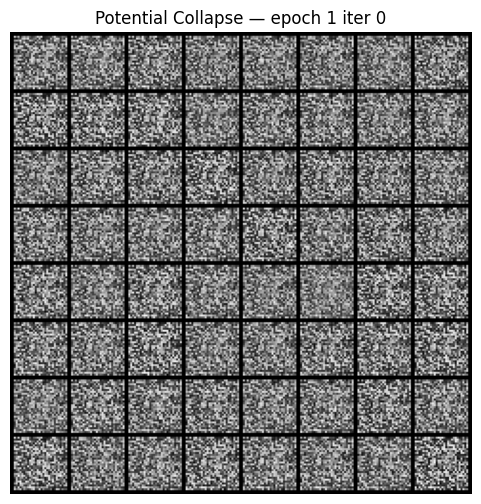

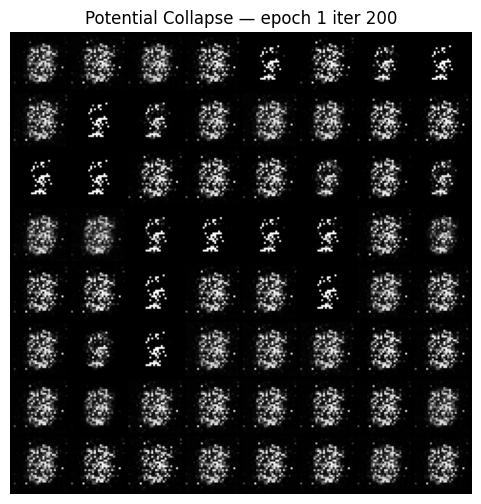

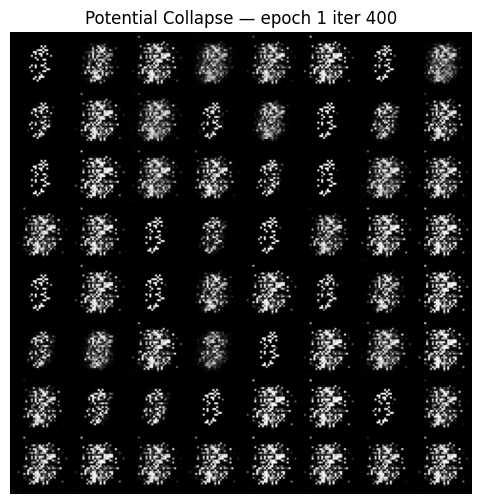

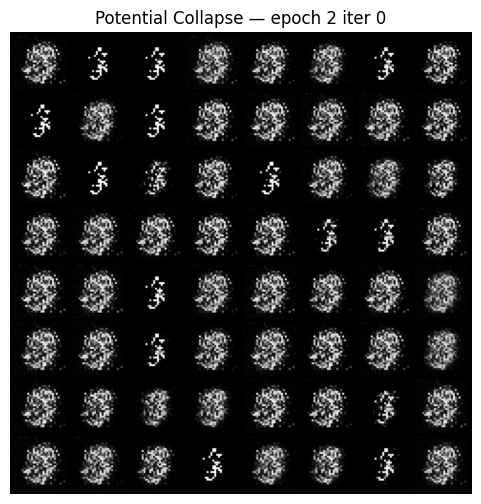

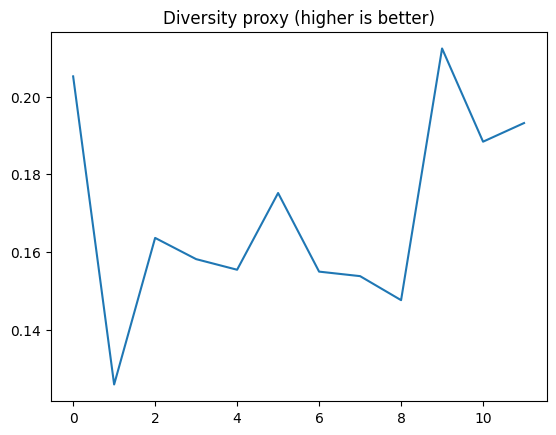

If collapse occurs, grids look very similar (same digit), and diversity proxy may drop/flatten.


In [15]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g*5, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d, betas=(CFG.beta1, CFG.beta2))
def diversity_score(imgs): return imgs.view(imgs.size(0),-1).std(dim=0).mean().item()
div_hist=[]
for epoch in range(1,5):
    for i,(imgs,_) in enumerate(train_dl):
        d,g,_,_ = one_step(imgs, label_smooth=None, d_steps=1, g_steps=3)
        if i%200==0:
            with torch.no_grad(): fake=G(torch.randn(64, CFG.z_dim, device=device)).view(-1,1,28,28).cpu()
            div_hist.append(diversity_score(fake))
            if len(div_hist)<=4: plot_grid(fake, title=f'Potential Collapse — epoch {epoch} iter {i}')
plt.figure(); plt.plot(div_hist); plt.title('Diversity proxy (higher is better)'); plt.show()
print('If collapse occurs, grids look very similar (same digit), and diversity proxy may drop/flatten.')

## 15. Mitigation — Strengthen D / Balanced Steps

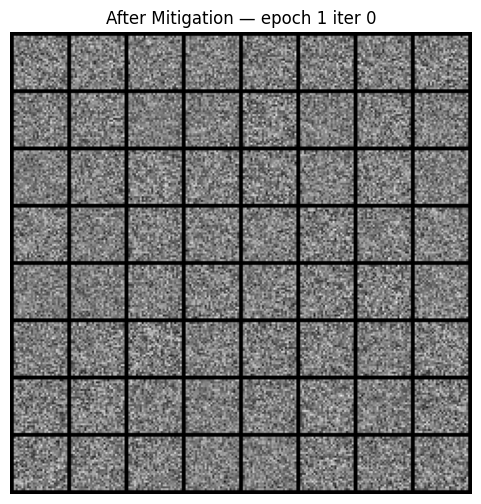

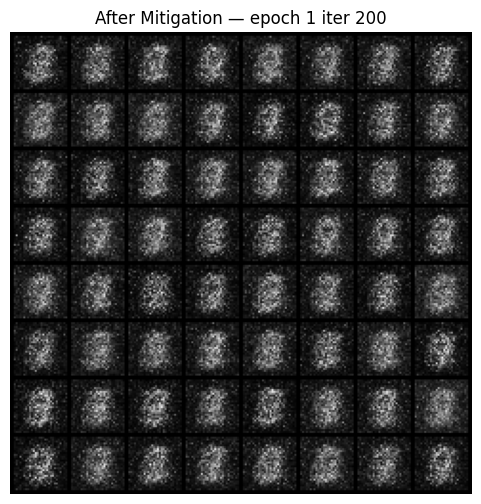

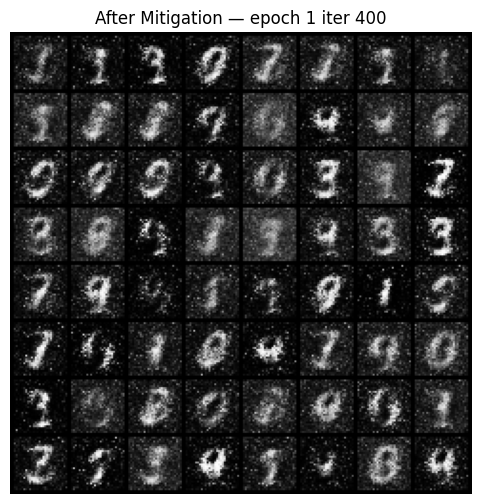

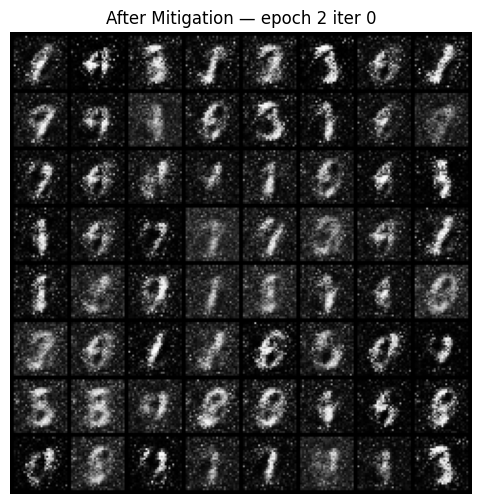

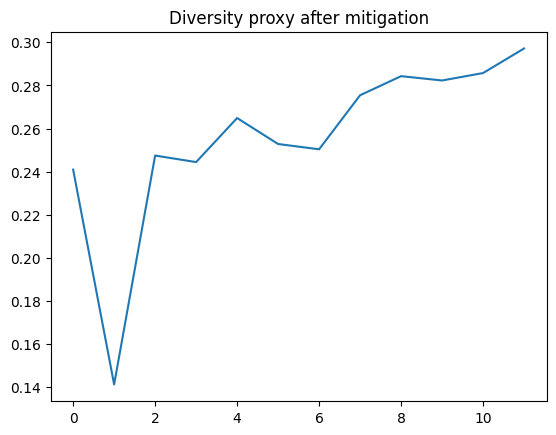

In [16]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d*2, betas=(CFG.beta1, CFG.beta2))
div_hist2=[]
for epoch in range(1,5):
    for i,(imgs,_) in enumerate(train_dl):
        d,g,_,_ = one_step(imgs, label_smooth=True, d_steps=2, g_steps=1)
        if i%200==0:
            with torch.no_grad(): fake=G(torch.randn(64, CFG.z_dim, device=device)).view(-1,1,28,28).cpu()
            div_hist2.append(diversity_score(fake))
            if len(div_hist2)<=4: plot_grid(fake, title=f'After Mitigation — epoch {epoch} iter {i}')
plt.figure(); plt.plot(div_hist2); plt.title('Diversity proxy after mitigation'); plt.show()

## 16. Experiment 3 — Discriminator Overfitting (limited data)

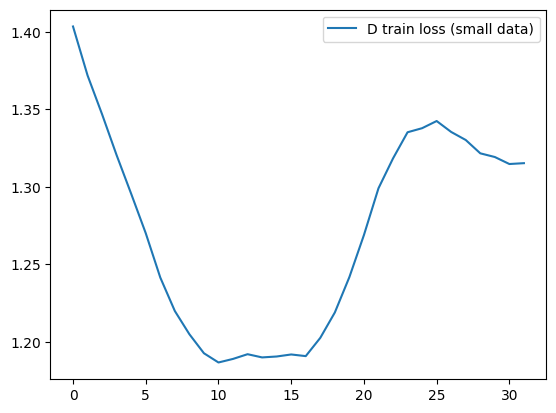

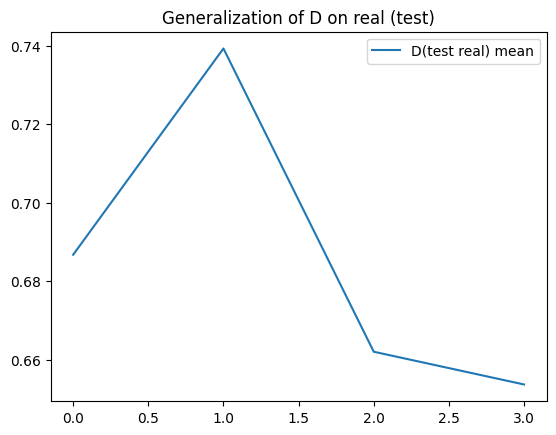

In [17]:
small_idx=list(range(1000))
small_ds=Subset(train_ds, small_idx)
small_dl=DataLoader(small_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.workers, pin_memory=(device.type=='cuda'), persistent_workers=(CFG.workers>0))
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.0).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d, betas=(CFG.beta1, CFG.beta2))
train_loss_d=[]; test_real_vals=[]
for epoch in range(1,5):
    for imgs,_ in small_dl:
        d,g,_,_ = one_step(imgs, label_smooth=None, d_steps=1, g_steps=1)
        train_loss_d.append(d)
    with torch.no_grad():
        vals=[]
        for imgs,_ in test_dl:
            B=imgs.size(0); x=imgs.view(B,-1).to(device)
            vals.append(D(x).mean().item())
        test_real_vals.append(float(np.mean(vals)))
plt.figure(); plt.plot(train_loss_d, label='D train loss (small data)'); plt.legend(); plt.show()
plt.figure(); plt.plot(test_real_vals, label='D(test real) mean'); plt.legend(); plt.title('Generalization of D on real (test)'); plt.show()

## 17. Mitigation — Regularize D (Dropout)

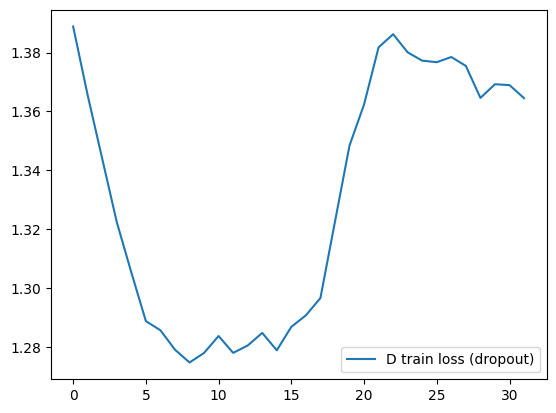

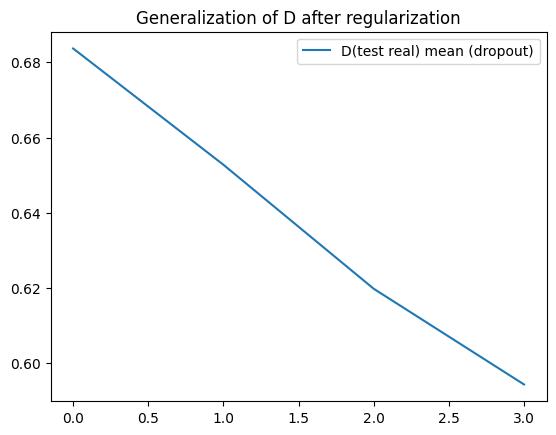

In [18]:
G = Generator(CFG.z_dim, CFG.g_hid, CFG.img_flat).apply(init_weights_normal).to(device)
D = Discriminator(CFG.img_flat, CFG.d_hid, p_drop=0.4).apply(init_weights_normal).to(device)
optG = torch.optim.Adam(G.parameters(), lr=CFG.lr_g, betas=(CFG.beta1, CFG.beta2))
optD = torch.optim.Adam(D.parameters(), lr=CFG.lr_d, betas=(CFG.beta1, CFG.beta2))
train_loss_d2=[]; test_real_vals2=[]
for epoch in range(1,5):
    for imgs,_ in small_dl:
        d,g,_,_ = one_step(imgs, label_smooth=True, d_steps=1, g_steps=1)
        train_loss_d2.append(d)
    with torch.no_grad():
        vals=[]
        for imgs,_ in test_dl:
            B=imgs.size(0); x=imgs.view(B,-1).to(device)
            vals.append(D(x).mean().item())
        test_real_vals2.append(float(np.mean(vals)))
plt.figure(); plt.plot(train_loss_d2, label='D train loss (dropout)'); plt.legend(); plt.show()
plt.figure(); plt.plot(test_real_vals2, label='D(test real) mean (dropout)'); plt.legend(); plt.title('Generalization of D after regularization'); plt.show()

## 18. Final Samples


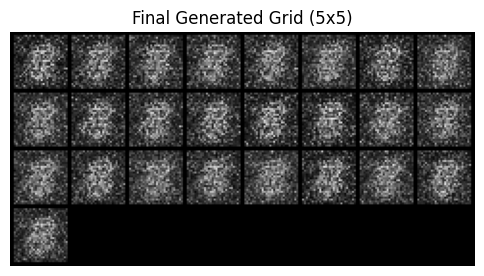

In [19]:
with torch.no_grad(): fake=G(torch.randn(25, CFG.z_dim, device=device)).view(-1,1,28,28).cpu()
plot_grid(fake, title='Final Generated Grid (5x5)')